In [152]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.style as style
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import euclidean
from tqdm.notebook import tqdm, trange

Задача проекта оценить взаимосвязь цены на золото и цены на биткоин и выявить воспринимается ли биткоин инвесторами в качестве "тихой гавани" во время кризиса наравне с золотом. Исторические данные по активам для данного проекта взяты за последний год, т.к. "коронакризис" является первым кризисом в истории биткоина.


1) Произвести расчет корреляции.

2) Построить модель линейной регрессии 

3) Оценить статистическую значимость уравнения линейной регрессии с помощью F-критерия Фишера.


In [6]:
df1 = pd.read_csv('gold.csv')
df2 = pd.read_csv('BTC.csv')

Так как торги по BTC идут каждый день, включая выходные, а золото торгуется на бирже только по будним дням, мы наблюдаем различие в количестве данных за один и тот же период. При слиянии датасетов это нужно учитывать, в данном случае убираем данные по торгам в выходные дни. 

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2242 entries, 0 to 2241
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Дата    2242 non-null   object
 1   Цена    2242 non-null   object
 2   Откр.   2242 non-null   object
 3   Макс.   2242 non-null   object
 4   Мин.    2242 non-null   object
 5   Объём   2242 non-null   object
 6   Изм. %  2242 non-null   object
dtypes: object(7)
memory usage: 122.7+ KB


In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3121 entries, 0 to 3120
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Дата    3121 non-null   object
 1   Цена    3121 non-null   object
 2   Откр.   3121 non-null   object
 3   Макс.   3121 non-null   object
 4   Мин.    3121 non-null   object
 5   Объём   3121 non-null   object
 6   Изм. %  3121 non-null   object
dtypes: object(7)
memory usage: 170.8+ KB


In [76]:
df = pd.merge(df1,df2,on='Дата')

In [77]:
df.head()

,Дата,Цена_x,Откр._x,Макс._x,Мин._x,Объём_x,Изм. %_x,Цена_y,Откр._y,Макс._y,Мин._y,Объём_y,Изм. %_y
0,21.08.2020,"1.947,00","1.955,60","1.963,10","1.916,60",-,"0,03%","11.531,0","11.884,0","11.889,0","11.531,0","6,10K","-2,97%"
1,20.08.2020,"1.946,50","1.934,40","1.963,10","1.928,90","383,34K","-1,21%","11.884,0","11.778,0","11.900,0","11.719,0","2,73K","0,90%"
2,19.08.2020,"1.970,30","2.010,50","2.015,60","1.930,50","443,26K","-2,13%","11.778,0","11.961,8","12.004,0","11.694,6","6,29K","-1,54%"
3,18.08.2020,"2.013,10","1.993,60","2.024,60","1.985,20","361,48K","0,72%","11.961,8","12.300,0","12.359,0","11.927,2","7,18K","-2,75%"
4,17.08.2020,"1.998,70","1.956,40","2.000,80","1.939,10","289,44K","2,51%","12.300,0","11.925,0","12.415,0","11.826,1","10,12K","3,14%"


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2241 entries, 0 to 2240
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Дата      2241 non-null   object
 1   Цена_x    2241 non-null   object
 2   Откр._x   2241 non-null   object
 3   Макс._x   2241 non-null   object
 4   Мин._x    2241 non-null   object
 5   Объём_x   2241 non-null   object
 6   Изм. %_x  2241 non-null   object
 7   Цена_y    2241 non-null   object
 8   Откр._y   2241 non-null   object
 9   Макс._y   2241 non-null   object
 10  Мин._y    2241 non-null   object
 11  Объём_y   2241 non-null   object
 12  Изм. %_y  2241 non-null   object
dtypes: object(13)
memory usage: 245.1+ KB


In [ ]:
df['Цена_x'] = df['Цена_x'].str.replace('.','')
df['Цена_y'] = df['Цена_y'].str.replace('.','')

In [ ]:
df['Цена_x'] = df['Цена_x'].str.replace(',','.')
df['Цена_y'] = df['Цена_y'].str.replace(',','.')

In [ ]:
df['Цена_x'] = df['Цена_x'].astype(float)
df['Цена_y'] = df['Цена_y'].astype(float)

Т.к. нас интересуют данные по активам за 2019 и 2020 годы, удалим более ранние данные. Для этого определяем индекс строки соответствующей введенной дате, а затем берем данные для датасета в соответствии с полученным индексом.  

In [ ]:
df.loc[(df['Дата'] == '01.01.2019')]

In [ ]:
df = df.head(435)
df.tail()

Расчет коэффициента корреляции

__Корреляция__ — математический показатель, по которому можно судить, есть ли статистическая взаимосвязь между двумя и более случайными величинами.

__Коэффициент корреляции__ принимает значения из отрезка $[-1, 1]$.

Если коэффициент корреляции близок к $1$, то между величинами наблюдается прямая связь: увеличение одной величины сопровождается увеличением другой, а уменьшение одной — уменьшением другой.

Если же коэффициент корреляции близок к $-1$, то между величинами есть обратная корреляционная связь: увеличение одной величины сопровождается уменьшением другой и наоборот.

Коэффициент корреляции, равный $0$, говорит о том, что между величинами нет связи, то есть величины изменяются независимо друг от друга.

In [116]:
df[['Цена_x', 'Цена_y']].corr()

,Цена_x,Цена_y
Цена_x,1.000000,0.591719
Цена_y,0.591719,1.000000


В результате получается матрица корреляций. Мы видим, что корреляция достаточно высока.

Посчитаем ковариацию. 

__Ковариация__ — мера линейной зависимости случайных величин. Её формула похожа на формулу дисперсии (_variance_). 

Формула ковариации случайных величин $X$ и $Y$:
$$\operatorname{cov}(X, Y) = M\left( (X - M(X)) (Y - M(Y)) \right).$$

Эту формулу можно раскрыть и упростить до
$$\operatorname{cov}(X, Y) = M(XY) - M(X) M(Y).$$

In [117]:
X = df['Цена_x']
Y = df['Цена_y']

MX = X.mean()
MY = Y.mean()

cov = ((X - MX) * (Y - MY)).mean()
cov

248093.97550122868

проверим себя с помощь библиотеки numpy:

In [153]:
cov = np.cov(X, Y)
cov

array([[  31291.1674634 ,  248665.62060607],
       [ 248665.62060607, 5643887.97680947]])

Эта функция возвращает не значение ковариации, а т.н. __матрицу ковариаций__. В ней по диагонали стоят вариации (т.е. дисперсии) каждой из выборок, а вне диагонали — попарные ковариации.

Исследуем зависимость цены биткоина от цены золота с помощью линейной регрессии 

__Линейная регрессия__ — используемая в статистике регрессионная модель зависимости _объясняемой_ переменной $y$ от другой или нескольких других переменных (_факторов_) $x$ с линейной функцией зависимости:
$$y = b_0 + b_1 x_1 + \dots + b_k x_k.$$

найдем коэффициенты линейной регресии

In [135]:
b1 = np.cov(X, Y, ddof=1)[0, 1] / np.var(X, ddof=1)
b1

7.94683103137447

In [136]:
b0 = Y.mean() - b1 * X.mean()
b0

-4304.165468805605

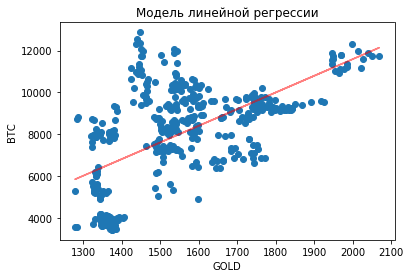

In [157]:
fig, (ax) = plt.subplots(ncols=1)
ox = X
oy = b0 + b1 * ox

ax.scatter(X, Y)
ax.plot(ox, oy, color='red', alpha=0.5)
ax.set_title('Модель линейной регрессии')

plt.xlabel('GOLD')
plt.ylabel('BTC');

Посчитаем коэффициент детерминации

In [138]:
z1 = b0 + b1 * X

print(f'real: {Y[:5]}')
print(f'pred: {z1[:5]}')

real: 0    11531.0
1    11884.0
2    11778.0
3    11961.8
4    12300.0
Name: Цена_y, dtype: float64
pred: 0    11168.314549
1    11164.341134
2    11353.475712
3    11693.600080
4    11579.165714
Name: Цена_x, dtype: float64


In [139]:
R1 = 1 - (z1 - Y).var() / Y.var()
R1

0.3501316252888165

Коэффициент детерминации, равный $0.35$, означает, что $35 \%$ дисперсии переменной $y$ _учитывается_ или _объясняется_ моделью. Оставшиеся $65 \%$ обусловлены какими-то ещё факторами, которые модель не учла.

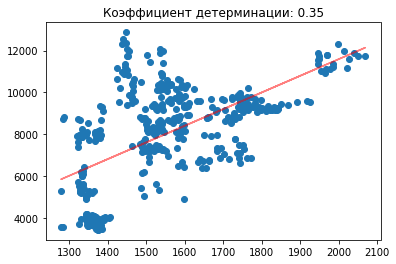

In [151]:
fig, (ax) = plt.subplots(ncols=1)
ax.scatter(X, Y)
ax.plot(X, b0 + b1 * X, color='red', alpha=0.5)
ax.set_title(f'Коэффициент детерминации: {round(np.corrcoef(X, Y)[0, 1] ** 2, 2)}')

plt.show()

Оценка значимости уравнения линейной регрессии

Оценить статистическую значимость уравнения линейной регрессии в целом можно с помощью __F-критерия Фишера__. Проверяется нулевая гипотеза о том, что все коэффициенты при факторах у регрессионной модели равны нулю (т.е. модель представляет из себя горизонтальную плоскость.)

Используемая здесь статистика:
$$F = \dfrac{R^2 / k}{(1 - R^2) / (n - k - 1)},$$
где $R^2$ — коэффициент детерминации, $n$ — число наблюдений, $k$ — число факторов. В литературе часто используются обозначения $k_1 = k$, $k_2 = n - k - 1$ (иногда вместо $k_1$, $k_2$ пишут также $f_1$, $f_2$).

Данную статистику можно понимать как отношение объяснённой дисперсии к необъяснённой.

Критическое значение $F_{сrit} = F(k_1, k_2)$ можно найти по таблице (например, по [такой](https://www.chem-astu.ru/science/reference/F-statistic.html)) или с помощью функции `scipy.stats.f.ppf`.

Если $F > F_{crit}$, то нулевая гипотеза отвергается и уравнение регрессии признаётся статистически значимым.

In [143]:
k1 = 1
k2 = len(X) - k1 - 1

F1 = (R1 / k1) / ((1 - R1) / k2)
F1

233.28876992581024

In [146]:
alpha = 0.05

F_crit = stats.f.ppf(1 - alpha, k1, k2)
F_crit

3.863024193455905

Имеем $F > F_{crit}$, поэтому уравнение регрессии статистически значимо.

Вывод: между котировками цен на оба, рассмотренных, актива имеется статистически значимая взаимосвязь.  